# Starbucks Capstone Challenge

- <a id='#TOC'>Table of Contents</a>
    - <a href='#Intro'>Introduction </a>
        - <a href='#Dataset'>Datasets definition </a>
        - <a href='#authornote'>Author Notes</a> 
    - <a href='#sec_0.0'>Section 0: Import Librarys and Data </a>
    - <a href='#sec_1.0'>Section 1: Clean and Organizae Data </a>
        - <a href='#sec_1_1'>Section 1.1: Match Transcript </a>
    - <a href='#sec_2.0'>Section 2: Explore Data </a>
        - <a href='#sec_2_1'>Section 2.1: Genreal Exploration </a>
        - <a href='#sec_2_2'>Section 2.2: Demographic Histographical Analysis </a>

<a id='Intro'></a>
## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

<a id='Dataset'></a>
### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


<a id='authornote'></a>
### Author Notes

Expanded notes on thought process are contained in <a href='Notes.ipynb'>Notes.ipynb Jupyter notebook</a> which is stored in the same directory

<a id='sec_0'></a>
## 0. Import Librarys and Data

In [1]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
tqdm.pandas()
import json
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

<a href='pick_load'>Jump to Pickle Load in Section 2</a>

<a id='sec_1'></a>
## 1. Clean and Organize Data

In [3]:
def clean_and_organize_data(portfolio=portfolio,profile=profile,transcript=transcript):
    ## Portfolio
    portfolio.rename(columns={'id':'offer_id'},inplace=True) # match other table
    # one hot encode channels
    mlb = MultiLabelBinarizer() 
    portfolio = portfolio.join(pd.DataFrame(mlb.fit_transform(portfolio.pop('channels')),
                          columns=mlb.classes_,
                          index=portfolio.index))
    portfolio = portfolio.merge(pd.get_dummies(portfolio['offer_type'],prefix='offer',prefix_sep='_x_'),left_index=True,right_index=True)
    portfolio.drop(columns='offer_type',inplace=True)
    portfolio.set_index('offer_id')
    ## Profile
    profile = profile.dropna(axis = 0)
    profile.loc[:,'became_member_on']=pd.to_datetime(profile['became_member_on'],format='%Y%m%d')
    profile = profile.merge(pd.get_dummies(profile['gender'],prefix='gender',prefix_sep='_x_'),left_index=True,right_index=True)
    #profile = profile.drop(columns='gender')
    #profile.set_index('id',inplace=True)
    ## Transcript
    # expand dict in value to its own columns per dict key
    transcript = transcript.merge(transcript.value.apply(pd.Series),left_index=True,right_index=True)
    # merge 
    transcript.loc[transcript['offer_id'].isna(),'offer_id'] = transcript[transcript['offer_id'].isna()]['offer id']
    transcript = transcript.merge(pd.get_dummies(transcript['event'],prefix='event',prefix_sep='_x_'),left_index=True, right_index=True)
    transcript.drop(columns = ['offer id','value'],inplace=True)
    transcript = transcript[transcript['person'].isin(profile.id)].reset_index()
    t_offer = transcript[transcript['event']=='offer received']
    t_viewed = transcript[transcript['event']=='offer viewed']
    t_trans = transcript[transcript['event']=='transaction']
    t_compl = transcript[transcript['event']=='offer completed']
    
    return portfolio,profile,transcript,t_offer,t_viewed,t_trans,t_compl

In [4]:
portfolio_new,profile_new,transcript_new,t_offer,t_viewed,t_trans,t_compl = clean_and_organize_data()

C:\Users\tcanty\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
print(portfolio.shape)
print(profile.shape)
print(transcript.shape)

(10, 5)
(17000, 5)
(306534, 4)


In [7]:
print(t_offer.shape)
print(t_viewed.shape)
print(t_compl.shape)
print(t_trans.shape)


(66501, 11)
(49860, 11)
(32444, 11)
(123957, 11)


In [25]:
print(portfolio_new.shape)
print(profile_new.shape)
print(transcript_new.shape)

(10, 11)
(14825, 8)
(272762, 11)


<a id='section1_1'></a>
### 1.1 Match transcript

In [8]:
portfolio.head(1)

,difficulty,duration,offer_id,offer_type,reward
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10


In [9]:
t_viewed.shape

(49860, 11)

In [10]:
'''Lookup the duration of each offer and convert to hours to match offer time data.
and create a time end'''
t_matched = pd.merge(t_offer,portfolio[['offer_id','duration']],on=['offer_id'],how='left')
t_matched['duration'] =t_matched['duration'].progress_apply(lambda x: x*24)
t_matched['time_end'] = t_matched['time'] + t_matched['duration']

'''  Merge view transcripts!'''

def id_viewed(row):
    '''
    '''
    for idx,trn in t_matched[t_matched.person == row.person].sort_values(by='time').iterrows():
        if (trn.time >= row.time) & (trn.time < row.time_end ):
            row['event_x_viewed'] = 1
            row['time_viewed'] = trn['time']
            return row
    return row

'''
t_matched = pd.merge(t_matched,t_viewed[['person','offer_id','time']],on=['person','offer_id'],how='left',suffixes=('','_viewed'))

def id_viewed(row):
    id_viewed - identify if 
        Input:
        row - to be used with pd.apply()
        Output:
        row - modified (if necessary)
    
    if (row['time_viewed'] >= row['time']) & (row['time_viewed'] < row['time_end']):
        row['event_x_offer viewed'] = 1
    else:
        row['event_x_offer viewed'] = 0
    return row
'''
t_matched = t_matched.progress_apply(id_viewed,axis=1)

100%|██████████| 66501/66501 [11:16<00:00, 98.34it/s] 


In [11]:
t_matched[(t_matched.person == '2eeac8d8feae4a8cad5a6af0499a211d') & (t_matched.offer_id == '3f207df678b143eea3cee63160fa8bed')]

,index,event,person,time,amount,offer_id,reward,event_x_offer completed,event_x_offer received,event_x_offer viewed,event_x_transaction,duration,time_end,event_x_viewed,time_viewed
3,7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0,0,96,96,1,0


In [13]:
''' merge transaction transcript!
'''
t_matched['trans_time'] = np.nan

t_matched['trans_index'] = np.nan


def scrub_trans(row):
    '''
    '''
    #print(row['person'])
    for idx,trn in t_trans[t_trans.person == row.person].sort_values(by='time').iterrows():
        if (trn.time >= row.time) & (trn.time < row.time_end ):
            row['event_x_transaction'] = 1
            row['trans_time'] = trn['time']
            row['trans_index'] = trn['index']
            return row
    return row
 

t_matched = t_matched.progress_apply(scrub_trans,axis=1)


''' Merge completed transactions
'''

t_matched['reward'] = np.nan

def scrub_compl(row):
    for idx,trn in t_compl[(t_compl.person == row.person)&(t_compl.offer_id == row.offer_id)].sort_values(by='time').iterrows():
        if (trn.time >= row.time) & (trn.time < row.time_end ):
            row['event_x_offer completed'] = 1
            row['reward'] = trn['reward']
            return row
    return row
 

t_matched = t_matched.progress_apply(scrub_compl,axis=1)

100%|██████████| 66501/66501 [13:27<00:00, 82.40it/s] 


In [14]:
''' Save df to pickle'''


t_matched.to_pickle('combined_trans.pkl')

In [15]:
t_matched2 = pd.read_pickle('combined_trans.pkl')

In [19]:
t_matched2.head(2)

,index,event,person,time,amount,offer_id,reward,event_x_offer completed,event_x_offer received,event_x_offer viewed,event_x_transaction,duration,time_end,event_x_viewed,time_viewed,trans_time,trans_index
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,1,0,1,168,168,1,0,132.0,47582.0
1,2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,168,168,1,0,NaN,NaN


In [18]:
t_matched2.columns

Index(['index', 'event', 'person', 'time', 'amount', 'offer_id', 'reward',
       'event_x_offer completed', 'event_x_offer received',
       'event_x_offer viewed', 'event_x_transaction', 'duration', 'time_end',
       'event_x_viewed', 'time_viewed', 'trans_time', 'trans_index'],
      dtype='object')

In [23]:
t_matched2_new = t_matched2[['index','person','offer_id','time','duration','time_end','time_viewed','trans_time','trans_index','reward','event_x_offer completed', 'event_x_offer received',
       'event_x_offer viewed', 'event_x_transaction']]

In [24]:
t_matched2_new.head()

,index,person,offer_id,time,duration,time_end,time_viewed,trans_time,trans_index,reward,event_x_offer completed,event_x_offer received,event_x_offer viewed,event_x_transaction
0,0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,168,168,0,132.0,47582.0,5.0,1,1,0,1
1,2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,168,168,0,NaN,NaN,NaN,0,1,0,0
2,5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,120,120,0,60.0,32625.0,5.0,1,1,0,1
3,7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,96,96,0,NaN,NaN,NaN,0,1,0,0
4,8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,240,240,0,210.0,83400.0,NaN,0,1,0,1


<a id='pickleload'></a>

<a id='sec_2'></a>
## Section 2: Demographic Analysis

In [8]:
profile_new.head()

,age,became_member_on,gender,id,income,gender_x_F,gender_x_M,gender_x_O
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0


In [9]:
profile_new['memb_leng'] = (profile_new.became_member_on.max()-profile_new.became_member_on).dt.days.astype(float)/30.416

In [10]:
profile_new.head()

,age,became_member_on,gender,id,income,gender_x_F,gender_x_M,gender_x_O,memb_leng
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,12.361915
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,14.564703
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,2.991846
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,5.490531
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,8.449500


C:\Users\tcanty\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


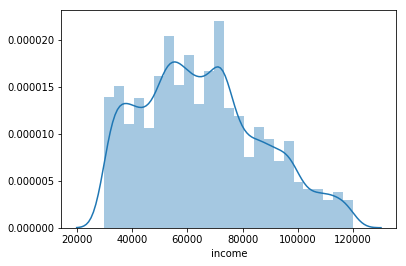

In [11]:

sns.distplot(profile_new.income,bins=25)

In [12]:
#it appears that there are some groupings in this distribution

In [13]:
profile_new[['gender_x_M','gender_x_F','gender_x_O']].sum()

gender_x_M    8484
gender_x_F    6129
gender_x_O     212
dtype: int64

C:\Users\tcanty\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


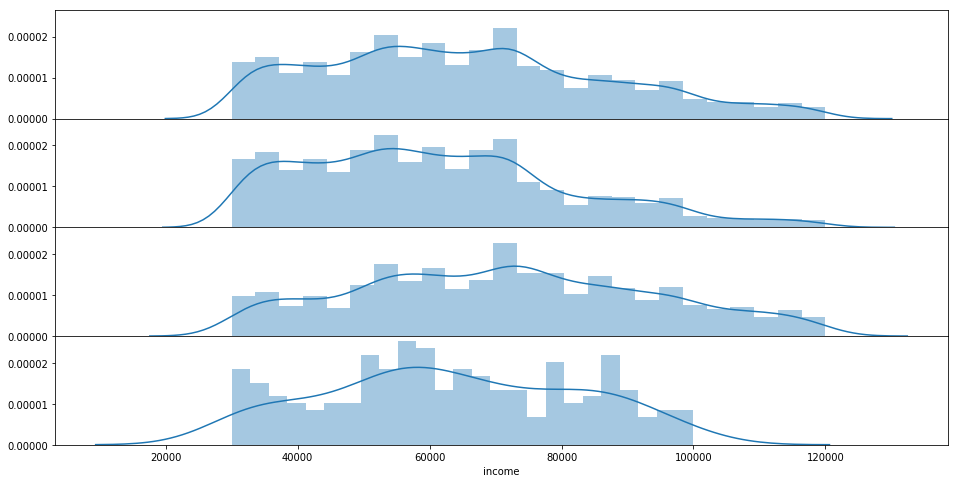

In [14]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, sharex=True,sharey=True, figsize=(16,8))
fig.subplots_adjust(hspace = 0)
sns.distplot(profile_new.income,bins=25,ax=ax0)
sns.distplot(profile_new[profile_new.gender_x_M == 1].income,bins=25,ax=ax1)
sns.distplot(profile_new[profile_new.gender_x_F == 1].income,bins=25,ax=ax2)
sns.distplot(profile_new[profile_new.gender_x_O == 1].income,bins=25,ax=ax3)

There appears to be groupings within the income, that are not related to gender.  It apppears to be 3-5 subgroups.  There are possibly something implit here.

C:\Users\tcanty\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


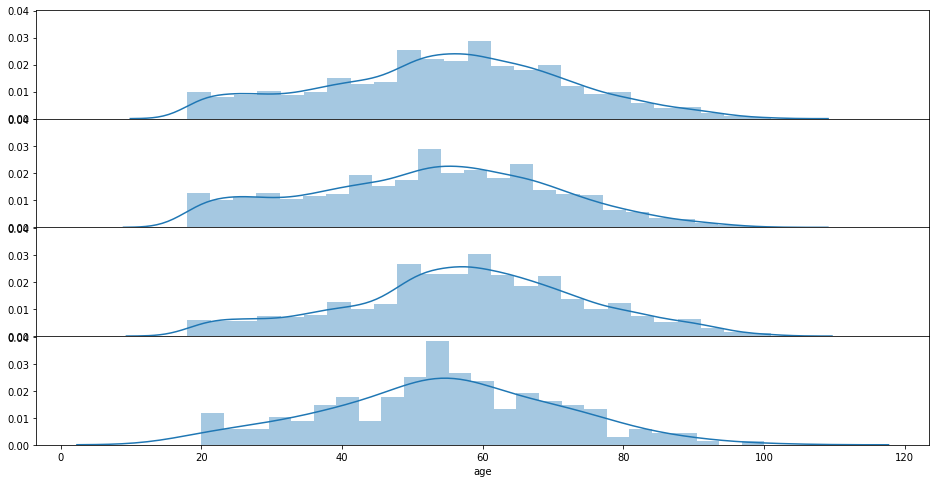

In [15]:


fig2, (ax2_0, ax2_1, ax2_2, ax2_3) = plt.subplots(nrows=4, sharey= True, sharex=True,figsize=(16,8))
fig2.subplots_adjust(hspace = 0)
sns.distplot(profile_new.age,bins=25,ax=ax2_0)
sns.distplot(profile_new[profile_new.gender_x_M == 1].age,bins=25,ax=ax2_1)
sns.distplot(profile_new[profile_new.gender_x_F == 1].age,bins=25,ax=ax2_2)
sns.distplot(profile_new[profile_new.gender_x_O == 1].age,bins=25,ax=ax2_3)

There does appear to be two groupings here within the data

C:\Users\tcanty\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


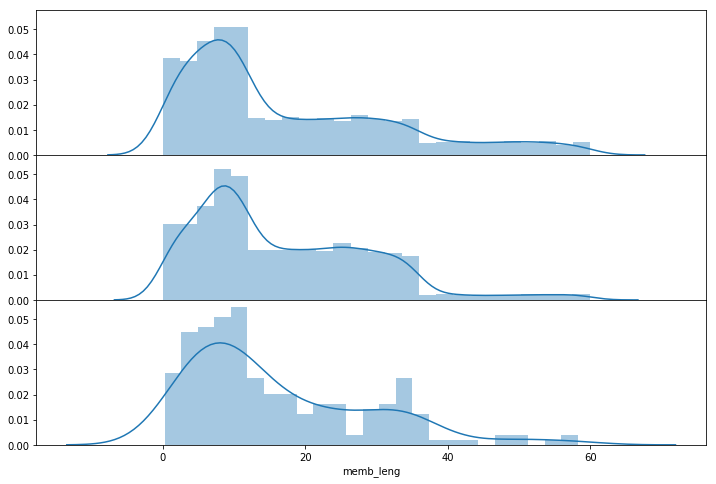

In [16]:
fig3, (ax3_1, ax3_2, ax3_3) = plt.subplots(nrows=3, sharex=True,sharey=True, figsize=(12,8))
fig3.subplots_adjust(hspace = 0)
sns.distplot(profile_new[profile_new.gender_x_M == 1].memb_leng,bins=25,ax=ax3_1)
sns.distplot(profile_new[profile_new.gender_x_F == 1].memb_leng,bins=25,ax=ax3_2)
sns.distplot(profile_new[profile_new.gender_x_O == 1].memb_leng,bins=25,ax=ax3_3)

There appears to be 3 distinct groups of members based on membership length
* members joining between ~38-58months
* members joining between ~12-38 months
* members joining in last 12 months 



C:\Users\tcanty\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


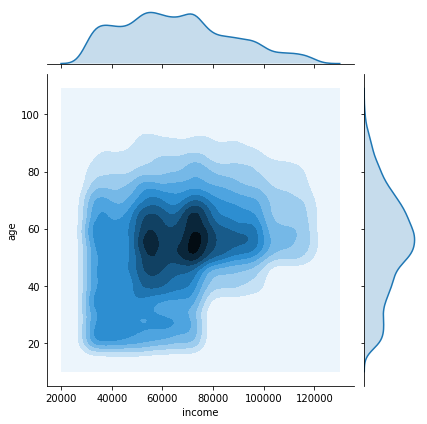

In [17]:
sns.jointplot(x='income',y='age',data=profile_new,kind="kde")

C:\Users\tcanty\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


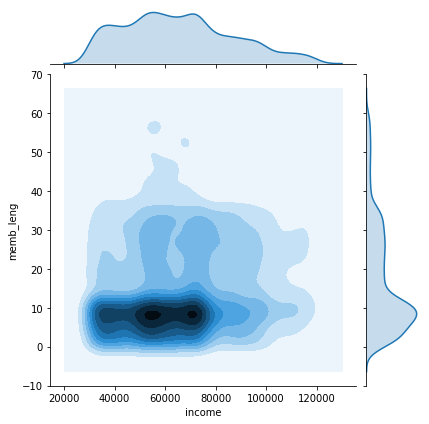

In [18]:
sns.jointplot(x=profile_new.income,y=profile_new.memb_leng,kind="kde")

It appears that the early and mid adopters tend to be distributed roughly the same as the general population.  

C:\Users\tcanty\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


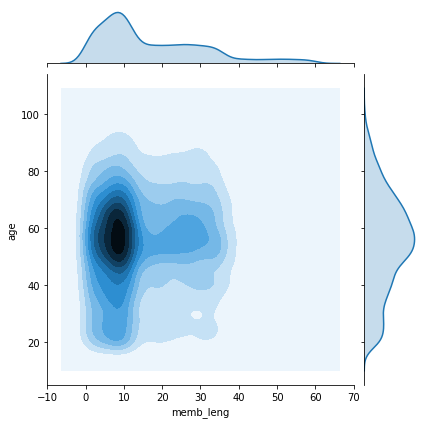

In [19]:
sns.jointplot(x='memb_leng',y='age',data=profile_new,kind="kde")

### Figure Out transactions

In [20]:
peeps = t_offer.person.unique()[0:5]
    

In [21]:
peeps

array(['78afa995795e4d85b5d9ceeca43f5fef',
       'e2127556f4f64592b11af22de27a7932',
       '389bc3fa690240e798340f5a15918d5c',
       '2eeac8d8feae4a8cad5a6af0499a211d',
       'aa4862eba776480b8bb9c68455b8c2e1'], dtype=object)

In [22]:
offer_test = t_offer[t_offer.person.isin(peeps)]

In [23]:
offer_test.shape

(22, 11)

In [24]:
offer_test.head(1)

,index,event,person,time,amount,offer_id,reward,event_x_offer completed,event_x_offer received,event_x_offer viewed,event_x_transaction
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0


In [25]:
portfolio[portfolio.offer_id == offer_test.iloc[0].offer_id]['duration'].values[0]*24

168

In [28]:
for idx,row in tqdm(t_offer.iterrows(),total=t_offer.shape[0]):
    t_start = row.time
    t_end = t_start + (portfolio[portfolio.offer_id == row.offer_id]['duration'].values[0]*24)
    if (t_viewed[(t_viewed.person == row.person) &
            (t_viewed.offer_id == row.offer_id)&
            (t_viewed.time >= t_start) &
            (t_viewed.time < t_end)]).any().any():
        t_offer.loc[idx,'event_x_offer viewed'] = 1
    else:
        t_offer.loc[idx,'event_x_offer viewed'] = 0
    

  0%|          | 0/66501 [00:00<?, ?it/s]C:\Users\tcanty\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
100%|██████████| 66501/66501 [1:27:50<00:00, 13.69it/s]  


In [29]:
t_offer.to_pickle('t_offer.pkl')

In [8]:
t_offer = pd.read_pickle('t_offer.pkl')

In [9]:
t_offer.head()

,index,event,person,time,amount,offer_id,reward,event_x_offer completed,event_x_offer received,event_x_offer viewed,event_x_transaction
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,1,1,0
1,2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,1,0
2,5,offer received,389bc3fa690240e798340f5a15918d5c,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1,1,1,0
3,7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0,0
4,8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,1,0


In [10]:
for idx,row in tqdm(t_offer.iterrows(),total=t_offer.shape[0]):
    t_start = row.time
    t_end = t_start + (portfolio[portfolio.offer_id == row.offer_id]['duration'].values[0]*24)
    if (t_trans[(t_trans.person == row.person) &
            (t_trans.offer_id == row.offer_id)&
            (t_trans.time >= t_start) &
            (t_trans.time < t_end)]).any().any():
        t_offer.loc[idx,'event_x_transaction'] = 1
    else:
        t_offer.loc[idx,'event_x_transaction'] = 0
    

 15%|█▍        | 9935/66501 [07:24<44:52, 21.01it/s]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\thoma\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-cfaeaab6b47d>", line 6, in <module>
    (t_trans.time >= t_start) &
  File "C:\Users\thoma\Anaconda3\lib\site-packages\pandas\core\ops.py", line 1829, in wrapper
    other = fill_int(other) if is_other_int_dtype else fill_bool(other)
  File "C:\Users\thoma\Anaconda3\lib\site-packages\pandas\core\ops.py", line 1815, in <lambda>
    fill_bool = lambda x: x.fillna(False).astype(bool)
  File "C:\Users\thoma\Anaconda3\lib\site-packages\pandas\core\generic.py", line 5691, in astype
    **kwargs)
  File "C:\Users\thoma\Anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 531, in astype
    return self.apply('astype', dtype=dtype, **kwargs)
  File "C:\Users\thoma\Anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 395, in apply
    applied =

KeyboardInterrupt: 

In [ ]:
t_offer.to_pickle('t_offer.pkl')

In [12]:
for idx,row in tqdm(t_offer.iterrows(),total=t_offer.shape[0]):
    t_start = row.time
    t_end = t_start + (portfolio[portfolio.offer_id == row.offer_id]['duration'].values[0]*24)
    if (t_compl[(t_compl.person == row.person) &
            (t_compl.offer_id == row.offer_id)&
            (t_compl.time >= t_start) &
            (t_compl.time < t_end)]).any().any():
        t_offer.loc[idx,'event_x_offer completed'] = 1
    else:
        t_offer.loc[idx,'event_x_offer completed'] = 0

100%|██████████| 66501/66501 [20:04<00:00, 55.21it/s]


In [13]:
t_offer.to_pickle('t_offer.pkl')

In [9]:
t_offer = pd.read_pickle('t_offer.pkl')

In [11]:
t_offer.head()

,index,event,person,time,amount,offer_id,reward,event_x_offer completed,event_x_offer received,event_x_offer viewed,event_x_transaction
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,1,1,0
1,2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,1,0
2,5,offer received,389bc3fa690240e798340f5a15918d5c,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1,1,1,0
3,7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0,0
4,8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,1,0


In [365]:
off_time0_0 + dur0*24

168

In [373]:
t_viewed[(t_viewed.person==peeps[0])&(t_viewed.offer_id == offer0_0)&(t_viewed.time >= off_time0_0)&(t_viewed.time < (off_time0_0 + dur0*24))].any().any()

True

In [374]:
t_viewed[(t_viewed.person==peeps[0])&(t_viewed.offer_id == offer0_0)&(t_viewed.time >= off_time0_0)&(t_viewed.time < (5))].any().any()

False

In [375]:
for idx,row in t_offer.iterrows():
    t_viewed[(t_viewed.person = row.person) &
             (t_viewed.offer_id = row.offer_id) &
             (t_viewed.time >= row.time) &
             (t_viewed.time < (row.time))
        

array(['78afa995795e4d85b5d9ceeca43f5fef',
       'e2127556f4f64592b11af22de27a7932',
       '389bc3fa690240e798340f5a15918d5c', ...,
       'd825b707198046e39baa4fdcfa11d621',
       'c207a8a8ef5c47ee970ca45f859e07eb',
       '9a3f45cf29ef428b932492c7a5d6ac52'], dtype=object)

In [ ]:
user_offer = t_offer.pivot_table(values = 'event_x_offer received',columns='offer_id',index = 'person',aggfunc='sum')

In [ ]:
user_offer.head()

In [ ]:
user_offer.max(axis=1).max()
    

In [14]:
test_user = 'c8a71dc7d32c402e85e2eb3cbe0ad68a'  # has 6 offers

In [18]:
next(t_offer[t_offer['person']==test_user].iterrows())[1]['offer_id']

'0b1e1539f2cc45b7b9fa7c272da2e1d7'

In [19]:
t_viewed[t_viewed.person==test_user].offer_id.isin(['0b1e1539f2cc45b7b9fa7c272da2e1d7'])

80355     False
127354    False
193536    False
232320    False
Name: offer_id, dtype: bool

In [20]:
t_viewed[(t_viewed.person==test_user) & (t_viewed.offer_id=='0b1e1539f2cc45b7b9fa7c272da2e1d7')]['time']

Series([], Name: time, dtype: int64)

## 2. Explore Data

In [ ]:
tot_offers = t_offer.shape[0]
tot_viewed = t_viewed.shape[0]
tot_completed = t_compl.shape[0]
tot_num_purchased = t_trans.shape[0]
tot_sum_purch = t_trans.amount.sum()
tot_sum_reward = t_compl.reward.sum()

print('Percentage viewed : {0:.2f}%'.format(100* tot_viewed/tot_offers))
print('Percentage completed : {0:.2f}%'.format(100*tot_completed/tot_offers))
print('Percentage of purchases that were rewarded  : {0:.2f}%'.format(100*tot_completed/tot_num_purchased))

* we want to separate out transactions that were either not replaced to an offer nor not viewed.
* get transations that were not offers and 

In [ ]:
print(t_offer.shape)
t_offer.head()

In [ ]:
print(t_viewed.shape)
t_viewed.head()

In [ ]:
t_offer_view = t_offer.merge(t_viewed,how='outer',left_on=['person','offer_id'],right_on=['person','offer_id'])

In [ ]:
print(t_offer_view.shape)
t_offer_view.head()

In [ ]:
t_offer_view[t_offer_view['event_y'].isna()]

In [ ]:
offered.values

In [ ]:
offer_viewed = np.intersect1d(offered.values,viewed.values).tolist()

In [ ]:
transcript.loc[(transcript['offer_id'].isin(offer_viewed))&(transcript['person'].isin(test_1_ids)),'purc_viewed']=True

In [ ]:
transcript[transcript['person'].isin(test_1_ids)]

In [ ]:
def user_and_option(arr1, arr2):
    #function per user jterrace via Stack Overflow
    arr1_view = arr1.view([('',arr1.dtype)]*arr1.shape[1])
    arr2_view = arr2.view([('',arr2.dtype)]*arr2.shape[1])
    intersected = numpy.intersect1d(arr1_view, arr2_view)
    return intersected.view(arr1.dtype).reshape(-1, arr1.shape[1])